In [7]:
import pandas as pd
import cv2

def get_csv_length(csv_path):
    df = pd.read_csv(csv_path)
    return len(df)


def get_video_length(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    video_length = frame_count / fps
    cap.release()
    return video_length, frame_count

person = 'Z106'

csv_path = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person}/313-2-1-15-{person}_D.csv'
video_path = f'C:/Users/jk/action_assess_2/data/output/video_key/{person}/313-2-1-15-{person}_D_keypoints.avi'
video_path_original = f'C:/Users/jk/action_assess_2/data/video/{person}/313-2-1-15-{person}_D.avi'

csv_length = get_csv_length(csv_path)
video_length, frame_count = get_video_length(video_path)
video_length_original, frame_count_original = get_video_length(video_path_original )

print(f"CSV 파일의 길이: {csv_length} 행")
print(f"비디오 파일의 프레임 수: {frame_count} 프레임")
print(f"원본 비디오 파일의 프레임 수: {frame_count_original} 프레임")

CSV 파일의 길이: 32 행
비디오 파일의 프레임 수: 32 프레임
원본 비디오 파일의 프레임 수: 32 프레임


# main


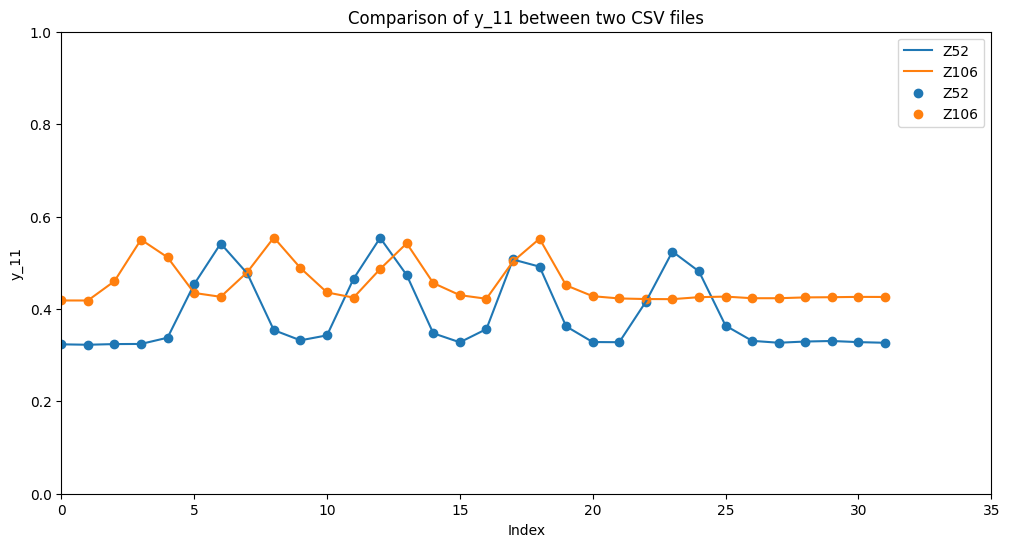

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_csv_columns(csv_path1, csv_path2, column_name):
    df1 = pd.read_csv(csv_path1)
    df2 = pd.read_csv(csv_path2)
    
    if column_name not in df1.columns or column_name not in df2.columns:
        print(f"Column {column_name} not found in one of the CSV files.")
        return
    
    plt.figure(figsize=(12, 6))
    # 선
    plt.plot(df1[column_name], label=f'{person1}')
    plt.plot(df2[column_name], label=f'{person2}')
    # 점
    plt.scatter(df1.index, df1[column_name],  label=f'{person1}')
    plt.scatter(df2.index, df2[column_name],  label=f'{person2}')
    
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.ylim(0,1)
    plt.xlim(0,35)
    plt.title(f'Comparison of {column_name} between two CSV files')
    plt.legend()
    plt.show()

person1 = 'Z52'
person2 = 'Z106'
trial = "313"
base = "317"

csv_path1 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person1}/{base}-2-1-15-{person1}_D.csv'
csv_path2 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person2}/{trial}-2-1-15-{person2}_D.csv'
column_name = 'y_11'

plot_csv_columns(csv_path1, csv_path2, column_name)


In [40]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def shift(data, shift_amount):
    data_series = pd.Series(data, dtype='float64')
    shifted_data = data_series.shift(-shift_amount, fill_value=data_series.iloc[-1])
    return shifted_data 

def calculate_cosine_similarity(window1, window2):
    window1 = np.array(window1).reshape(1, -1)
    window2 = np.array(window2).reshape(1, -1)
    similarity = cosine_similarity(window1, window2)
    return similarity

def max_idx_cosine_similarity(seg1, window2):
    similarities = []
    window_size = len(window2)
    for i in range(len(seg1) - (window_size - 1)):
        window_of_seg1 = seg1[i:i+window_size]
        similarity = calculate_cosine_similarity(window_of_seg1, window2)
        similarities.append(similarity)
    max_idx = similarities.index(max(similarities))
    return max_idx

    


In [46]:
import matplotlib.pyplot as plt
import os
import json  # 추가

max_idx = 0
person1 = 'Z52'
person2 = 'Z106'

base = '317'
for trial in range(313, 314):

    csv_path1 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person1}/{base}-2-1-15-{person1}_D.csv'
    csv_path2 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person2}/{trial}-2-1-15-{person2}_D.csv'
    column_name = 'y_11'

    df1 = pd.read_csv(csv_path1)
    df2 = pd.read_csv(csv_path2)

    shift_amount = -4
    df1_shifted = shift(df1[column_name], shift_amount)
    df2_shifted = shift(df2[column_name], shift_amount)

    shift_amount_2 = 5
    df1_shifted_shifted = shift(df1_shifted, shift_amount_2)

    segment_size = 7
    window_size = 3

    max_idx_list = []
    for i in range(min(len(df1), len(df2))):

        if column_name not in df1.columns or column_name not in df2.columns:
            print(f"Column {column_name} not found in one of the CSV files.")
        else:
            
            plt.figure(figsize=(12, 6))
            plt.axvline(x=-shift_amount, color='red', linestyle='--')
            plt.axvline(x=i, color='blue', linestyle='--', label=f'i = {i}')
            #plt.axvline(x=i-segment_size, color='blue', linestyle='--', label=f'i-1 = {i-segment_size}')

            plt.plot(df1_shifted_shifted[i-segment_size:i+1], label=f'{person1}_seg', color='blue', linewidth=5)
            plt.plot(df2_shifted[i-window_size:i+1], label=f'{person2}_seg', color='red', linewidth=5)

            if i >= segment_size:
                seg1 = df1_shifted_shifted[i-segment_size:i+1]
                window2 = df2_shifted[i-window_size:i+1]
                max_idx = max_idx_cosine_similarity(seg1, window2)
                max_idx_list.append(max_idx)

                plt.plot(df1_shifted_shifted[i-segment_size+max_idx: i-segment_size+max_idx+window_size+1], label=f'{person1}_cs', color='yellow', linewidth=7)
                plt.plot(df1_shifted[i-segment_size+max_idx+shift_amount_2: i-segment_size+max_idx+shift_amount_2+window_size+1], label=f'{person1}_cs', color='yellow', linewidth=7)
                plt.axvline(x=i-segment_size+max_idx+shift_amount_2+window_size, color='blue', linestyle='--', label=f'searched_i = {i-segment_size+max_idx+shift_amount_2+window_size}')

                plt.axvline(x=i-segment_size+max_idx+window_size, color='black', linestyle='--', label=f'i-1 = {i-segment_size}')
            else:
                max_idx_list.append(0)
                
            # 선
            plt.plot(df2_shifted[:i+1], label=f'{person2}_shifted', color='orange')
            plt.plot(df1_shifted_shifted[:i+1], label=f'{person1}_shifted_shifted', color='purple')
            
            
            # 점
            plt.scatter(df1_shifted.index[:], df1_shifted[:], label=f'{person1}_shifted', s=100, color='green')
            plt.scatter(df2_shifted.index[:i+1], df2_shifted[:i+1], label=f'{person2}_shifted', s=100, color='orange')
            plt.scatter(df1_shifted_shifted.index[:i+1], df1_shifted_shifted[:i+1], label=f'{person1}_shifted_shifted', s=100, color='purple')

            plt.xlabel('Index')
            plt.ylabel(column_name)
            plt.ylim(0, 1)
            plt.xlim(0, 50)
            plt.xticks(ticks=range(0,51,1))
            plt.title(f'max_ids:{max_idx}, shift_amount:{shift_amount}, shift_amount2_{shift_amount_2}, seg:{segment_size}, win:{window_size}, i:{i}')
            plt.legend()

            # Ensure the directory exists
            output_dir = f'C:/Users/jk/action_assess_2/alignment/plots/trainer_{person1}_user_{person2}/base_{base}_trial_{trial}/'
            os.makedirs(output_dir, exist_ok=True)

            # Save the figure
            plt.savefig(f'{output_dir}plot_{i+1}.png')
            plt.close()

            max_idx_df = pd.DataFrame({
            'base': [i + max_idx + 1   for i, max_idx in enumerate(max_idx_list)], 
            'trial': list(range(len(max_idx_list))), 
            'max_idx': max_idx_list
            })
            max_idx_df.to_csv(f'{output_dir}max_idx_list.csv', index=False)

    print(f'trial {trial } is completed')

trial 313 is completed


In [8]:
import matplotlib.pyplot as plt
'''person1 = 'Z52'
person2 = 'Z106'
trial = '316'

csv_path1 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person1}/{trial}-2-1-15-{person1}_D.csv'
csv_path2 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person2}/{trial}-2-1-15-{person2}_D.csv'
column_name = 'y_11'
'''
df1 = pd.read_csv(csv_path1)
df2 = pd.read_csv(csv_path2)

shift_amount = 0
df1_shifted = shift(df1[column_name], shift_amount)
df2_shifted = shift(df2[column_name], shift_amount)

shift_amount_2 = 2
df1_shifted_shifted = shift(df1_shifted , shift_amount_2)

segment_size = 7
window_size = 3
    
max_idx_list = []
for i in range(min(len(df1), len(df2))):
    
    if column_name not in df1.columns or column_name not in df2.columns:
        print(f"Column {column_name} not found in one of the CSV files.")
    else:
        plt.figure(figsize=(12, 6))
        plt.axvline(x=-shift_amount, color='red', linestyle='--')
        plt.axvline(x=i, color='blue', linestyle='--', label = f'i = {i}')
        plt.axvline(x=i-segment_size, color='blue', linestyle='--', label = f'i-1 = {i-segment_size}')
        
        
        #plt.plot(df1_shifted_shifted[i-segment_size:i+1], label=f'{person1}_seg', color='blue', linewidth=5)
        plt.plot(df2_shifted[i-window_size:i+1], label=f'{person2}_seg', color='red', linewidth=5)
        
        if i >= segment_size:
            seg1 = df1_shifted_shifted[i-segment_size:i+1]
            window2 = df2_shifted[i-window_size:i+1]
            max_idx = max_idx_cosine_similarity(seg1, window2)
            max_idx_list.append(max_idx)

            #plt.plot(df1_shifted_shifted[i-segment_size+max_idx : i-segment_size+max_idx + window_size+1], label=f'{person1}_cs', color='yellow', linewidth=7)
            plt.plot(df1_shifted[i-segment_size+max_idx+shift_amount_2 : i-segment_size+max_idx+shift_amount_2 + window_size+1], label=f'{person1}_cs', color='yellow', linewidth=7)
            plt.axvline(x=i-segment_size+max_idx+window_size, color='black', linestyle='--', label = f'i-1 = {i-segment_size}')
        
        # 선
        plt.plot(df1_shifted[:], label=f'{person1}_shifted', color='green')
        plt.plot(df2_shifted[:i+1], label=f'{person2}_shifted', color='orange')
        #plt.plot(df1_shifted_shifted[:i+1], label=f'{person1}_shifted_shifted', color='purple')
        
        # 점
        plt.scatter(df1_shifted.index[:], df1_shifted[:],  label=f'{person1}_shifted', s=100, color='green')
        plt.scatter(df2_shifted.index[:i+1], df2_shifted[:i+1],  label=f'{person2}_shifted', s=100, color='orange')
        #plt.scatter(df1_shifted_shifted.index[:i+1], df1_shifted_shifted[:i+1],  label=f'{person1}_shifted_shifted', s=100, color='purple')

        plt.xlabel('Index')
        plt.ylabel(column_name)
        plt.ylim(0, 1)  
        plt.xlim(0, 50)
        plt.title(f'{max_idx}')
        plt.legend()
        
        # Save the figure
        plt.savefig(f'C:/Users/jk/action_assess_2/alignment/plots/plot_{i+1}.png')
        plt.close()
print(max_idx_list)
print(len(max_idx_list))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 4, 4, 1]
25


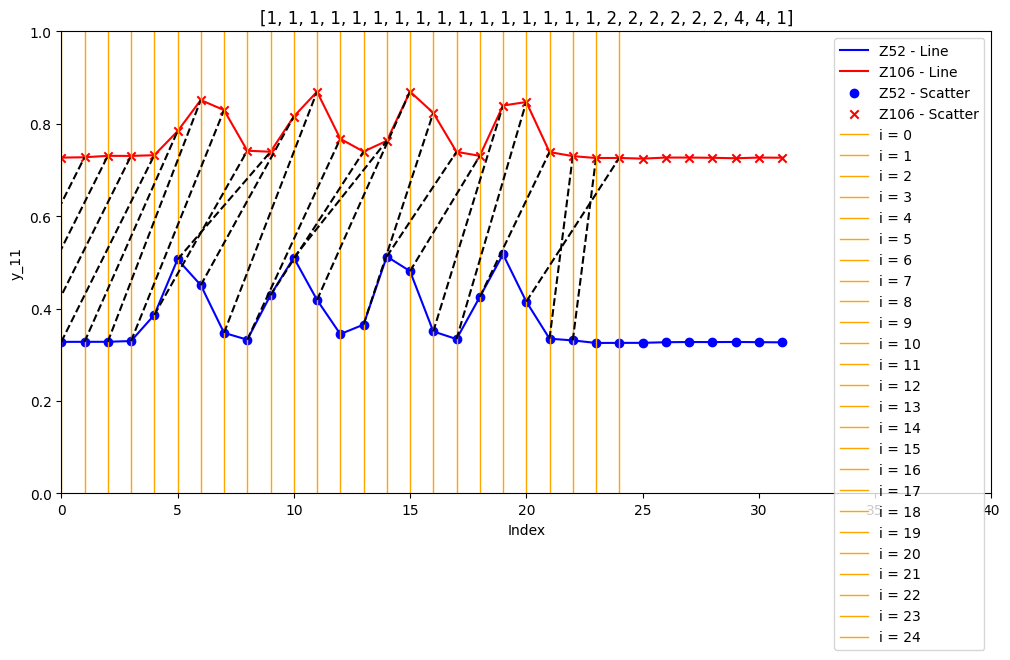

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_and_scatter(csv_path1, csv_path2, column_name, person1, person2, max_idx_list):
    df1 = pd.read_csv(csv_path1)
    df2 = pd.read_csv(csv_path2)
    
    if column_name not in df1.columns or column_name not in df2.columns:
        print(f"Column {column_name} not found in one of the CSV files.")
        return
    
    plt.figure(figsize=(12, 6))
    shift_amount_2 = 2
    segment_size = 7
    window_size = 3
    # 선
    plt.plot(df1[column_name], label=f'{person1} - Line', color='blue')
    plt.plot(df2[column_name] + 0.3, label=f'{person2} - Line', color='red')
    
    # 점
    plt.scatter(df1.index, df1[column_name], label=f'{person1} - Scatter', color='blue', marker='o')
    plt.scatter(df2.index, df2[column_name] + 0.3, label=f'{person2} - Scatter', color='red', marker='x')
    
    # Draw lines connecting corresponding points
    for i in range(min(50, len(max_idx_list))):
        k = i 
        plt.plot([i -segment_size + max_idx_list[k]+shift_amount_2 , i], [df1[column_name].iloc[i - segment_size + max_idx_list[k]+shift_amount_2 ], df2[column_name].iloc[i] + 0.3], color='black', linestyle='--')
        plt.axvline(x=i, color='orange', linestyle='-', linewidth=1, label=f'i = {i}')
    #plt.plot(df1_shifted[i-segment_size+max_idx+shift_amount_2 : i-segment_size+max_idx + window_size+1+shift_amount_2], label=f'{person1}_cs', color='yellow', linewidth=7)
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.xlim(0, 50)
    plt.ylim(0, 1)
    plt.title(f'{max_idx_list}')
    plt.legend()
    plt.xlim(0, 40)
    plt.ylim(0, 1)
    plt.show()

# Example usage
person1 = 'Z52'
person2 = 'Z106'
trial = "318"
column_name = 'y_11'

csv_path1 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person1}/{trial}-2-1-15-{person1}_D.csv'
csv_path2 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person2}/{trial}-2-1-15-{person2}_D.csv'

# Assuming max_idx_list is defined somewhere in your code
plot_and_scatter(csv_path1, csv_path2, column_name, person1, person2, max_idx_list)

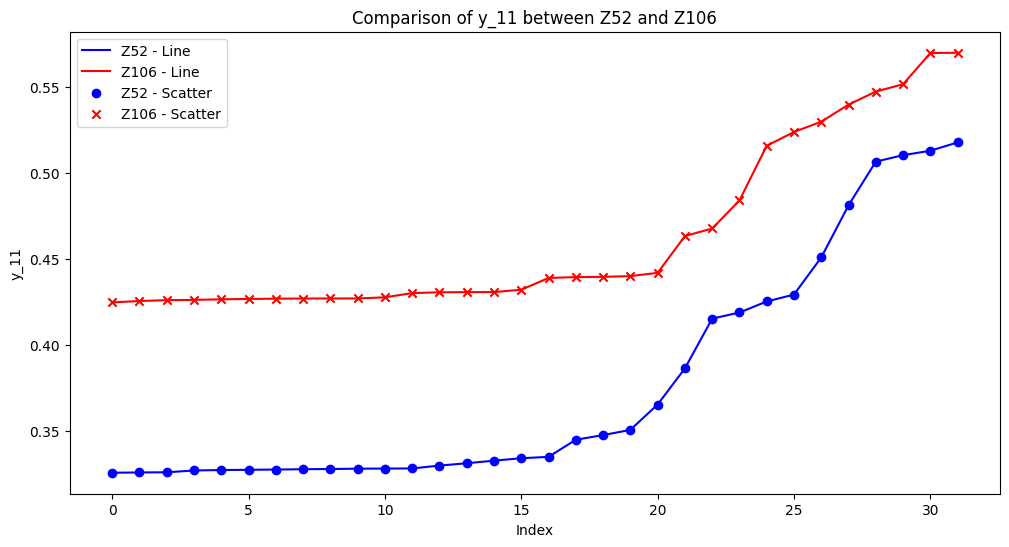

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

def align_and_plot(csv_path1, csv_path2, column_name, person1, person2):
    df1 = pd.read_csv(csv_path1)
    df2 = pd.read_csv(csv_path2)
    
    if column_name not in df1.columns or column_name not in df2.columns:
        print(f"Column {column_name} not found in one of the CSV files.")
        return
    
    # Sort the dataframes by the specified column
    df1_sorted = df1.sort_values(by=column_name).reset_index(drop=True)
    df2_sorted = df2.sort_values(by=column_name).reset_index(drop=True)
    
    plt.figure(figsize=(12, 6))
    
    # Plot lines
    plt.plot(df1_sorted[column_name], label=f'{person1} - Line', color='blue')
    plt.plot(df2_sorted[column_name], label=f'{person2} - Line', color='red')
    
    # Plot scatter points
    plt.scatter(df1_sorted.index, df1_sorted[column_name], label=f'{person1} - Scatter', color='blue', marker='o')
    plt.scatter(df2_sorted.index, df2_sorted[column_name], label=f'{person2} - Scatter', color='red', marker='x')
    
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.title(f'Comparison of {column_name} between {person1} and {person2}')
    plt.legend()
    plt.show()

# Example usage
person1 = 'Z52'
person2 = 'Z106'
trial = "318"
column_name = 'y_11'

csv_path1 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person1}/{trial}-2-1-15-{person1}_D.csv'
csv_path2 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person2}/{trial}-2-1-15-{person2}_D.csv'

align_and_plot(csv_path1, csv_path2, column_name, person1, person2)

In [8]:
import matplotlib.pyplot as plt
'''# Z106은 고정 52를 바꿔야 한다.
person1 = 'Z52' # 바꿈
person2 = 'Z106' # 고정
trial = "316"

csv_path1 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person1}/{trial}-2-1-15-{person1}_D.csv'
csv_path2 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person2}/{trial}-2-1-15-{person2}_D.csv'
column_name = 'y_11'
'''
df1 = pd.read_csv(csv_path1)
df2 = pd.read_csv(csv_path2)

for i in range(len(max_idx_list)):
    plt.figure(figsize=(12, 6))
    
    plt.axvline(x=i+max_idx_list[i], color='orange', linestyle='--', linewidth=4, label = f'i-1 = {i-segment_size}')
    plt.axvline(x=i+1, color='purple', linestyle='--', linewidth=2, label = f'i = {i}')
    # 선
    plt.plot(df1[column_name], label=f'{person1}',color = 'purple')
    plt.plot(df2[column_name], label=f'{person2}',color = 'orange')
    # 점
    plt.scatter(df1.index, df1[column_name],  label=f'{person1}', color = 'purple')
    plt.scatter(df2.index, df2[column_name],  label=f'{person2}', color = 'orange')

    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.ylim(0,1)
    plt.xlim(0,35)
    plt.title(f'Comparison of {column_name} between two CSV files')
    plt.legend()
    plt.savefig(f'C:/Users/jk/action_assess_2/alignment/plots2/plot_{i+1}.png')
    plt.close()


<function matplotlib.pyplot.show(close=None, block=None)>

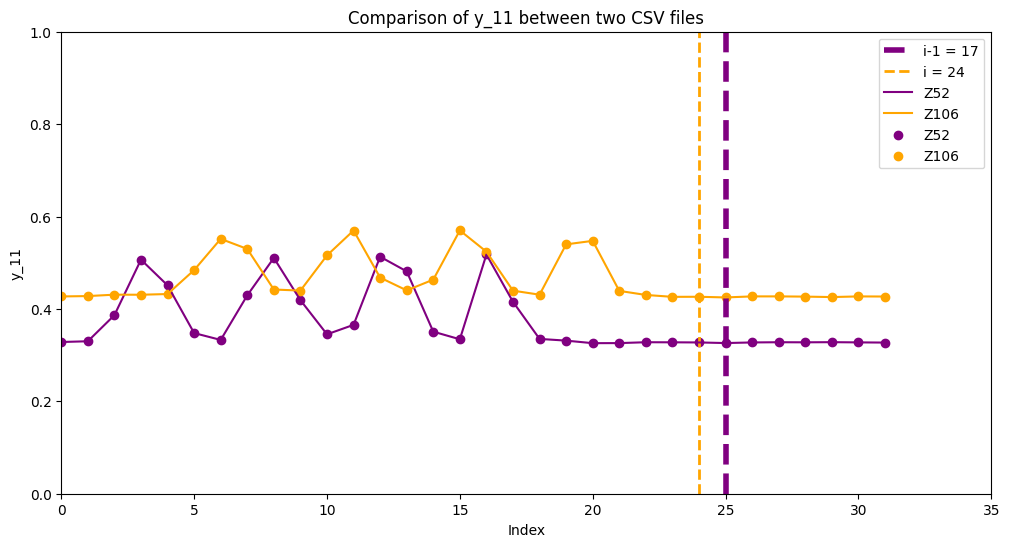

In [40]:
import matplotlib.pyplot as plt
'''# Z106은 고정 52를 바꿔야 한다.
person1 = 'Z52' # 바꿈
person2 = 'Z106' # 고정
trial = "316"

csv_path1 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person1}/{trial}-2-1-15-{person1}_D.csv'
csv_path2 = f'C:/Users/jk/action_assess_2/data/output/csv_key/{person2}/{trial}-2-1-15-{person2}_D.csv'
column_name = 'y_11'
'''
df1 = pd.read_csv(csv_path1)
df2 = pd.read_csv(csv_path2)

# Apply max_idx_list to df1
df1_aligned = df1.copy()
for i, max_idx in enumerate(max_idx_list):
    if i + max_idx < len(df1):
        df1_aligned.loc[i] = df1.loc[i + max_idx+1]

i=len(max_idx_list)-1

plt.figure(figsize=(12, 6))

plt.axvline(x=i+max_idx_list[i], color='purple', linestyle='--', linewidth=4, label = f'i-1 = {i-segment_size}')
plt.axvline(x=i, color='orange', linestyle='--', linewidth=2, label = f'i = {i}')
# 선
plt.plot(df1_aligned[column_name], label=f'{person1}', color='purple')
plt.plot(df2[column_name], label=f'{person2}', color='orange')
# 점
plt.scatter(df1_aligned.index, df1_aligned[column_name], label=f'{person1}', color='purple')
plt.scatter(df2.index, df2[column_name], label=f'{person2}', color='orange')

plt.xlabel('Index')
plt.ylabel(column_name)
plt.ylim(0, 1)
plt.xlim(0, 35)
plt.title(f'Comparison of {column_name} between two CSV files')
plt.legend()
plt.savefig(f'C:/Users/jk/action_assess_2/alignment/plots2/plot_{i+1}.png')
plt.show

In [9]:
import cv2

def create_aligned_video(video1_path, video2_path, max_idx_list, output_path):
    cap1 = cv2.VideoCapture(video1_path)
    cap2 = cv2.VideoCapture(video2_path)
    
    if not cap1.isOpened() or not cap2.isOpened():
        print("Error: Could not open one of the videos.")
        return
    
    # Get video properties
    fps = cap1.get(cv2.CAP_PROP_FPS)
    width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    out = cv2.VideoWriter(output_path, fourcc, fps, (width * 2, height))
    
    frame_idx = 0
    while cap1.isOpened() and cap2.isOpened():
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        
        if not ret1 or not ret2:
            break
        
        if frame_idx < len(max_idx_list):
            shift_amount = max_idx_list[frame_idx]
            if frame_idx + shift_amount < len(max_idx_list):
                cap1.set(cv2.CAP_PROP_POS_FRAMES, frame_idx + shift_amount)
                ret1, frame1 = cap1.read()
                if not ret1:
                    break
        
        # Concatenate frames horizontally
        combined_frame = cv2.hconcat([frame1, frame2])
        out.write(combined_frame)
        frame_idx += 1
    
    cap1.release()
    cap2.release()
    out.release()
    print(f"Aligned video saved to {output_path}")

# Example usage
video1_path = f'C:/Users/jk/action_assess_2/data/video/{person1}/316-2-1-15-{person1}_D.avi'
video2_path = f'C:/Users/jk/action_assess_2/data/video/{person2}/316-2-1-15-{person2}_D.avi'
output_path = f'C:/Users/jk/action_assess_2/alignment/aligned_video.avi'
create_aligned_video(video1_path, video2_path, max_idx_list, output_path)

Aligned video saved to C:/Users/jk/action_assess_2/alignment/aligned_video.avi


In [10]:
import cv2

def create_aligned_video(video1_path, video2_path, max_idx_list, output_path):
    cap1 = cv2.VideoCapture(video1_path)
    cap2 = cv2.VideoCapture(video2_path)
    
    if not cap1.isOpened() or not cap2.isOpened():
        print("Error: Could not open one of the videos.")
        return
    
    # Get video properties
    fps = cap1.get(cv2.CAP_PROP_FPS)
    width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    out = cv2.VideoWriter(output_path, fourcc, fps, (width * 2, height))
    
    frame_idx = 0
    while cap1.isOpened() and cap2.isOpened():
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        
        if not ret1 or not ret2:
            break
        
        
        # Concatenate frames horizontally
        combined_frame = cv2.hconcat([frame1, frame2])
        out.write(combined_frame)
        frame_idx += 1
    
    cap1.release()
    cap2.release()
    out.release()
    print(f"Aligned video saved to {output_path}")

# Example usage
video1_path = f'C:/Users/jk/action_assess_2/data/video/{person1}/316-2-1-15-{person1}_D.avi'
video2_path = f'C:/Users/jk/action_assess_2/data/video/{person2}/316-2-1-15-{person2}_D.avi'
output_path = f'C:/Users/jk/action_assess_2/alignment/simple_video.avi'
create_aligned_video(video1_path, video2_path, max_idx_list, output_path)

Aligned video saved to C:/Users/jk/action_assess_2/alignment/simple_video.avi
